In [2]:

# %% [Imports]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.utils import check_random_state




# Classification Analysis

This notebook covers classification using Decision Trees (ID3, CART), Naive Bayes, and Support Vector Machine (SVM). Model evaluation and comparison are included for each method.

## 1. Data Loading, Preprocessing, and Exploration

We will load the dataset, preprocess it to optimize classification performance, and visualize key aspects. Preprocessing includes handling missing values, encoding categorical variables, and scaling features. These steps are chosen to ensure models receive clean, numerical, and standardized data, which improves accuracy and comparability.

In [13]:
# %% [Data loading, pre-processing & exploration]
import time
import warnings
warnings.filterwarnings('ignore')

# Global config
RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)
plt.style.use("seaborn-v0_8")

# Increased sample sizes for better performance
TEST_SIZE = 0.2
N_SPLITS = 5
SAMPLE_SIZE_FOR_TRAINING = 150_000  # Much larger training set
SAMPLE_SIZE_FOR_GRID = 30_000       # Reasonable for grid search

DATA_PATH = "./data/movies_dataset.csv"
TARGET = "Genre"

# ============================================================================
# Load data and create features
# ============================================================================
print("=" * 80)
print("DATA LOADING & FEATURE ENGINEERING")
print("=" * 80)

df = pd.read_csv(DATA_PATH)
print(f"Original dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Parse release date
df["ReleaseDate"] = pd.to_datetime(df["ReleaseDate"], dayfirst=True, errors="coerce")
df["ReleaseMonth"] = df["ReleaseDate"].dt.month
df["ReleaseDay"] = df["ReleaseDate"].dt.day
df["ReleaseWeekday"] = df["ReleaseDate"].dt.weekday
df["ReleaseQuarter"] = df["ReleaseDate"].dt.quarter

# Financial ratios (key predictors)
df["ROI"] = df["Global_BoxOfficeUSD"] / (df["BudgetUSD"] + 1)
df["US_Share"] = df["US_BoxOfficeUSD"] / (df["Global_BoxOfficeUSD"] + 1)
df["Opening_Momentum"] = df["One_Week_SalesUSD"] / (df["Opening_Day_SalesUSD"] + 1)
df["Budget_Category"] = pd.qcut(df["BudgetUSD"], q=5, labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')

# Rating features
df["Rating_Consensus"] = (df["IMDbRating"] / 10 + df["RottenTomatoesScore"] / 100) / 2
df["Rating_Gap"] = df["IMDbRating"] / 10 - df["RottenTomatoesScore"] / 100
df["Popularity_Score"] = np.log1p(df["NumVotesIMDb"] + df["NumVotesRT"])
df["Vote_Ratio"] = df["NumVotesIMDb"] / (df["NumVotesRT"] + 1)

# Encode Director and LeadActor (top frequent + "Other")
top_n_directors = 50
top_n_actors = 50

top_directors = df['Director'].value_counts().head(top_n_directors).index
df['Director_Encoded'] = df['Director'].apply(lambda x: x if x in top_directors else 'Other_Director')

top_actors = df['LeadActor'].value_counts().head(top_n_actors).index
df['LeadActor_Encoded'] = df['LeadActor'].apply(lambda x: x if x in top_actors else 'Other_Actor')

# Country grouping
top_countries = df['Country'].value_counts().head(9).index
df['Country_Grouped'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# ============================================================================
# Feature selection
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE SELECTION")
print("=" * 80)

features_num = [
    # Temporal
    "ReleaseYear", "ReleaseMonth", "ReleaseQuarter", "ReleaseWeekday",
    # Financial (avoid high correlation)
    "BudgetUSD", "Global_BoxOfficeUSD", "Opening_Day_SalesUSD",
    # Ratios (highly informative)
    "ROI", "US_Share", "Opening_Momentum",
    # Ratings
    "Rating_Consensus", "Rating_Gap", "Popularity_Score", "Vote_Ratio",
    "IMDbRating", "RottenTomatoesScore"
]

features_cat = [
    "Country_Grouped", 
    "Budget_Category",
    "Director_Encoded", 
    "LeadActor_Encoded"
]

X_full = df[features_num + features_cat].copy()
y_full = df[TARGET].copy()

print(f"Numeric features: {len(features_num)}")
print(f"Categorical features: {len(features_cat)}")
print(f"Total features: {len(features_num) + len(features_cat)}")

# ============================================================================
# Data exploration
# ============================================================================
print("\n" + "=" * 80)
print("DATA EXPLORATION")
print("=" * 80)

print(f"\nTotal samples: {len(df):,}")
print(f"Number of classes: {y_full.nunique()}")
print(f"\nClass distribution:")
class_dist = y_full.value_counts()
for genre, count in class_dist.items():
    pct = count / len(y_full) * 100
    print(f"  {genre:15s}: {count:7,} ({pct:5.2f}%)")

print(f"\nClass balance:")
print(f"  Most frequent: {class_dist.max():,} ({class_dist.idxmax()})")
print(f"  Least frequent: {class_dist.min():,} ({class_dist.idxmin()})")
print(f"  Imbalance ratio: {class_dist.max() / class_dist.min():.2f}:1")

# ============================================================================
# Stratified sampling (LARGER sample)
# ============================================================================
print("\n" + "=" * 80)
print("STRATIFIED SAMPLING")
print("=" * 80)

def stratified_sample(X, y, n_per_class):
    """Sample data while maintaining class balance."""
    parts = []
    for cls in y.unique():
        idx = y[y == cls].index
        take = min(n_per_class, len(idx))
        sampled = rng.choice(idx, size=take, replace=False)
        parts.append(pd.DataFrame({"i": sampled}))
    sel = pd.concat(parts)["i"].values
    return X.loc[sel].copy(), y.loc[sel].copy()

# Create LARGER training set
n_per_class_train = SAMPLE_SIZE_FOR_TRAINING // y_full.nunique()
X_large, y_large = stratified_sample(X_full, y_full, n_per_class_train)

print(f"Target samples per class: {n_per_class_train:,}")
print(f"Total size after sampling: {len(X_large):,}")
print(f"\nClass distribution after sampling:")
for genre, count in y_large.value_counts().items():
    print(f"  {genre:15s}: {count:,}")

# ============================================================================
# Train/test split
# ============================================================================
print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X_large, y_large, test_size=TEST_SIZE, stratify=y_large, random_state=RANDOM_STATE
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# ============================================================================
# Preprocessing pipelines
# ============================================================================
print("\n" + "=" * 80)
print("PREPROCESSING PIPELINES")
print("=" * 80)

numeric_std = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

numeric_minmax = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_oh = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep_std = ColumnTransformer(
    transformers=[
        ("num", numeric_std, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

prep_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_minmax, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

print("Preprocessor with StandardScaler ready")
print("Preprocessor with MinMaxScaler ready")

# Test preprocessing
X_train_test = prep_std.fit_transform(X_train)
print(f"\nShape after preprocessing: {X_train_test.shape}")
print(f"  Original features: {len(features_num) + len(features_cat)}")
print(f"  After One-Hot encoding: {X_train_test.shape[1]}")

# ============================================================================
# Evaluation function
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATION SETUP")
print("=" * 80)

def evaluate_model(name, model, X_te, y_te, verbose=True):
    """Evaluate model performance."""
    start = time.time()
    y_pred = model.predict(X_te)
    pred_time = time.time() - start
    
    acc = accuracy_score(y_te, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    
    if verbose:
        print(f"\n{'=' * 80}")
        print(f"{name}")
        print(f"{'=' * 80}")
        metrics_df = pd.DataFrame({
            "Metric": ["Accuracy", "Precision (macro)", "Recall (macro)", "F1-Score (macro)", "Prediction time"],
            "Value": [f"{acc:.4f}", f"{pr:.4f}", f"{rc:.4f}", f"{f1:.4f}", f"{pred_time:.3f}s"]
        })
        print(metrics_df.to_string(index=False))
        
        print(f"\nConfusion Matrix:")
        cm = confusion_matrix(y_te, y_pred)
        cm_df = pd.DataFrame(cm, 
                             index=[f"True_{c}" for c in sorted(y_te.unique())],
                             columns=[f"Pred_{c}" for c in sorted(y_te.unique())])
        print(cm_df)
        
        print(f"\nClassification Report:")
        print(classification_report(y_te, y_pred, zero_division=0))
    
    return {
        "model": name, 
        "accuracy": acc, 
        "precision_macro": pr, 
        "recall_macro": rc, 
        "f1_macro": f1,
        "prediction_time": pred_time
    }

print("Evaluation function ready")

print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE")
print("=" * 80)
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features after encoding: {X_train_test.shape[1]}")
print("\nReady to train models!")

DATA LOADING & FEATURE ENGINEERING
Original dataset: 999,999 rows, 17 columns

FEATURE SELECTION
Numeric features: 16
Categorical features: 4
Total features: 20

DATA EXPLORATION

Total samples: 999,999
Number of classes: 8

Class distribution:
  Drama          : 250,018 (25.00%)
  Comedy         : 199,832 (19.98%)
  Action         : 150,131 (15.01%)
  Thriller       : 100,071 (10.01%)
  Romance        : 100,021 (10.00%)
  Horror         : 100,010 (10.00%)
  Documentary    :  50,114 ( 5.01%)
  Sci-Fi         :  49,802 ( 4.98%)

Class balance:
  Most frequent: 250,018 (Drama)
  Least frequent: 49,802 (Sci-Fi)
  Imbalance ratio: 5.02:1

STRATIFIED SAMPLING
Target samples per class: 18,750
Total size after sampling: 150,000

Class distribution after sampling:
  Comedy         : 18,750
  Documentary    : 18,750
  Drama          : 18,750
  Horror         : 18,750
  Action         : 18,750
  Thriller       : 18,750
  Romance        : 18,750
  Sci-Fi         : 18,750

TRAIN/TEST SPLIT
Trainin

## 3. Decision Trees (ID3 & CART)

We will train and evaluate Decision Tree classifiers using both ID3 (entropy) and CART (gini) criteria.

ID3 (entropía)

DECISION TREE - ID3 (Entropy-based) - OPTIMIZED

Preparing data...
Training set shape: (120000, 133)
Test set shape: (30000, 133)
Number of classes: 8

Class distribution in training:
Genre
Action         15000
Comedy         15000
Documentary    15000
Drama          15000
Horror         15000
Romance        15000
Sci-Fi         15000
Thriller       15000
Name: count, dtype: int64

STEP 1: BASELINE MODEL (default parameters)

Baseline training completed in 14.59s
Tree depth: 30
Number of leaves: 1958

Baseline performance:
  Training accuracy: 0.2179
  Test accuracy: 0.1259
  Overfitting gap: 0.0920

Baseline predictions distribution:
Action         2840
Comedy         3171
Documentary    2476
Drama          5110
Horror         4834
Romance        1997
Sci-Fi         4210
Thriller       5362
Name: count, dtype: int64

STEP 2: HYPERPARAMETER TUNING (relaxed constraints)

Creating sample for GridSearch...
GridSearch sample size: 24,000
Classes in grid sample:
Genre
Action         3000
Co

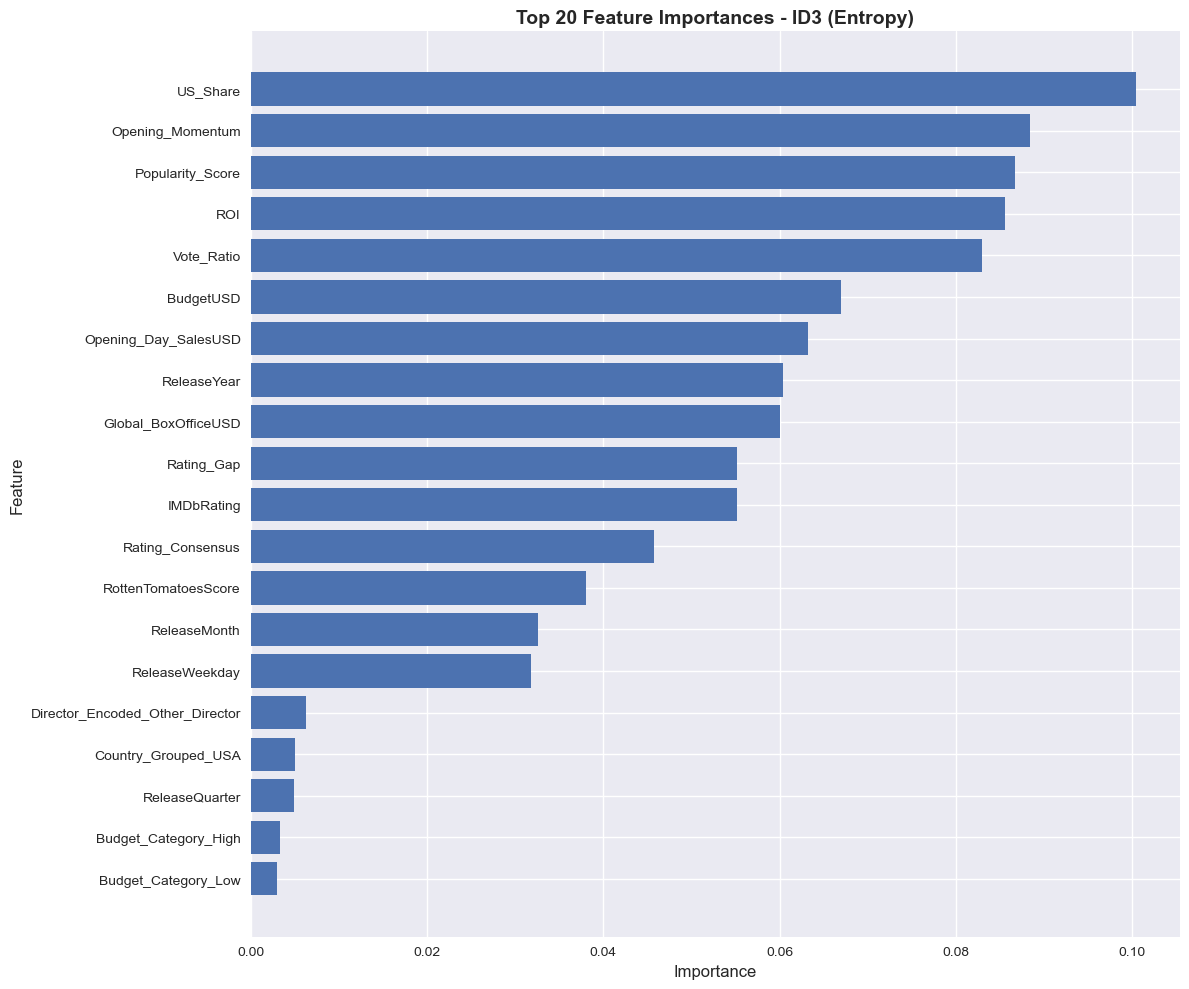


TREE VISUALIZATION

Tree too large to visualize (1958 leaves)

MODEL EVALUATION

ID3 (entropy-based)
           Metric  Value
         Accuracy 0.1259
Precision (macro) 0.1262
   Recall (macro) 0.1259
 F1-Score (macro) 0.1226
  Prediction time 0.020s

Confusion Matrix:
                  Pred_Action  Pred_Comedy  Pred_Documentary  Pred_Drama  \
True_Action               352          383               283         607   
True_Comedy               338          403               353         636   
True_Documentary          389          397               315         654   
True_Drama                353          409               303         637   
True_Horror               338          402               317         634   
True_Romance              356          380               308         654   
True_Sci-Fi               329          397               313         634   
True_Thriller             385          400               284         654   

                  Pred_Horror  Pred_Romance 

In [16]:
# %% [Decision Trees - ID3 (entropy-based) - FIXED]
from sklearn.tree import plot_tree
import time

print("=" * 80)
print("DECISION TREE - ID3 (Entropy-based) - OPTIMIZED")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep = prep_std.fit_transform(X_train)
X_test_prep = prep_std.transform(X_test)

print(f"Training set shape: {X_train_prep.shape}")
print(f"Test set shape: {X_test_prep.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"\nClass distribution in training:")
print(y_train.value_counts().sort_index())

# ============================================================================
# STEP 1: Quick baseline model (no tuning)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: BASELINE MODEL (default parameters)")
print("=" * 80)

baseline_id3 = DecisionTreeClassifier(
    criterion='entropy',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=30,  # Reasonable depth
    min_samples_split=50,
    min_samples_leaf=20
)

start_time = time.time()
baseline_id3.fit(X_train_prep, y_train)
baseline_time = time.time() - start_time

print(f"\nBaseline training completed in {baseline_time:.2f}s")
print(f"Tree depth: {baseline_id3.get_depth()}")
print(f"Number of leaves: {baseline_id3.get_n_leaves()}")

# Baseline predictions
y_train_pred_baseline = baseline_id3.predict(X_train_prep)
y_test_pred_baseline = baseline_id3.predict(X_test_prep)

train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_acc_baseline = accuracy_score(y_test, y_test_pred_baseline)

print(f"\nBaseline performance:")
print(f"  Training accuracy: {train_acc_baseline:.4f}")
print(f"  Test accuracy: {test_acc_baseline:.4f}")
print(f"  Overfitting gap: {(train_acc_baseline - test_acc_baseline):.4f}")

print(f"\nBaseline predictions distribution:")
print(pd.Series(y_test_pred_baseline).value_counts().sort_index())

# ============================================================================
# STEP 2: Grid search with RELAXED parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: HYPERPARAMETER TUNING (relaxed constraints)")
print("=" * 80)

# Much more relaxed parameter grid
param_grid_id3 = {
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 30],
    'min_impurity_decrease': [0.0, 0.0001, 0.0005],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.0001, 0.0005]  # Post-pruning
}

# Create smaller sample for grid search (faster)
print("\nCreating sample for GridSearch...")
n_per_class_grid = min(3000, len(y_train) // len(y_train.unique()))
X_grid_df, y_grid = stratified_sample(X_train, y_train, n_per_class_grid)
X_grid = prep_std.fit_transform(X_grid_df)

print(f"GridSearch sample size: {len(X_grid):,}")
print(f"Classes in grid sample:")
print(y_grid.value_counts().sort_index())

dt_id3_base = DecisionTreeClassifier(
    criterion='entropy',
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

grid_id3 = GridSearchCV(
    dt_id3_base,
    param_grid_id3,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',  # Optimize F1 instead of accuracy for balanced metrics
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV...")
start_time = time.time()
grid_id3.fit(X_grid, y_grid)
grid_time = time.time() - start_time

print(f"\nGridSearch completed in {grid_time/60:.1f} minutes")
print(f"Best parameters: {grid_id3.best_params_}")
print(f"Best CV F1-score (macro): {grid_id3.best_score_:.4f}")

# Show top 10 parameter combinations
results_df = pd.DataFrame(grid_id3.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 10 parameter combinations:")
for idx, row in top_10.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")

# ============================================================================
# STEP 3: Train final model with best parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: TRAINING FINAL MODEL")
print("=" * 80)

best_id3 = DecisionTreeClassifier(
    criterion='entropy',
    **grid_id3.best_params_,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

start_time = time.time()
best_id3.fit(X_train_prep, y_train)
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f}s")
print(f"Tree depth: {best_id3.get_depth()}")
print(f"Number of leaves: {best_id3.get_n_leaves()}")
print(f"Number of nodes: {best_id3.tree_.node_count}")

# Check if tree actually grew
if best_id3.get_depth() == 0:
    print("\n⚠️  ERROR: Tree did not grow! Using baseline model instead...")
    best_id3 = baseline_id3

# Training performance
y_train_pred = best_id3.predict(X_train_prep)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = precision_recall_fscore_support(y_train, y_train_pred, average='macro', zero_division=0)[2]

print(f"\nTraining performance:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  F1-score (macro): {train_f1:.4f}")

# ============================================================================
# STEP 4: Feature importance
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

feature_names_expanded = []
for name, transformer, cols in prep_std.transformers_:
    if name == "num":
        feature_names_expanded.extend(cols)
    elif name == "cat":
        encoder = transformer.named_steps['onehot']
        cat_features = encoder.get_feature_names_out(cols)
        feature_names_expanded.extend(cat_features)

importance_df = pd.DataFrame({
    'feature': feature_names_expanded,
    'importance': best_id3.feature_importances_
}).sort_values('importance', ascending=False)

# Show only features with importance > 0
important_features = importance_df[importance_df['importance'] > 0]
print(f"\nNumber of features used: {len(important_features)}")
print(f"\nTop 25 Most Important Features:")
print(important_features.head(25).to_string(index=False))

# Plot top 20
if len(important_features) > 0:
    plt.figure(figsize=(12, 10))
    top_features = important_features.head(20)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 20 Feature Importances - ID3 (Entropy)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# STEP 5: Tree visualization
# ============================================================================
print("\n" + "=" * 80)
print("TREE VISUALIZATION")
print("=" * 80)

if best_id3.get_depth() > 0 and best_id3.get_n_leaves() <= 200:
    print(f"\nGenerating tree visualization (first 4 levels)...")
    
    fig, ax = plt.subplots(figsize=(35, 20))
    plot_tree(
        best_id3,
        filled=True,
        feature_names=feature_names_expanded,
        class_names=[str(c) for c in sorted(best_id3.classes_)],
        rounded=True,
        fontsize=7,
        max_depth=4,
        ax=ax,
        proportion=True,
        precision=2,
        impurity=True
    )
    plt.title(f"ID3 Decision Tree (first 4 of {best_id3.get_depth()} levels)", 
              fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print(f"Note: Full tree has {best_id3.get_depth()} levels and {best_id3.get_n_leaves()} leaves")
elif best_id3.get_depth() == 0:
    print("\n⚠️  Tree did not grow - cannot visualize")
else:
    print(f"\nTree too large to visualize ({best_id3.get_n_leaves()} leaves)")

# ============================================================================
# STEP 6: Comprehensive model evaluation
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

res_id3 = evaluate_model("ID3 (entropy-based)", best_id3, X_test_prep, y_test, verbose=True)

# ============================================================================
# STEP 7: Detailed analysis
# ============================================================================
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 80)

y_test_pred = best_id3.predict(X_test_prep)

# Per-class metrics
print("\nPer-class performance:")
per_class_metrics = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
per_class_df = pd.DataFrame(per_class_metrics).transpose()
per_class_df = per_class_df[per_class_df.index.isin(sorted(y_test.unique()))]
per_class_df = per_class_df.sort_values('f1-score', ascending=False)
print(per_class_df[['precision', 'recall', 'f1-score', 'support']].to_string())

# Overfitting analysis
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {res_id3['accuracy']:.4f}")
print(f"Gap: {(train_acc - res_id3['accuracy']):.4f}")

if train_acc - res_id3['accuracy'] > 0.20:
    print("\n⚠️  Significant overfitting detected")
    print("Recommendations: increase min_samples_leaf, decrease max_depth, or increase ccp_alpha")
elif train_acc - res_id3['accuracy'] < 0.05:
    print("\n⚠️  Possible underfitting - model might be too constrained")
    print("Recommendations: decrease min_samples_leaf, increase max_depth")
else:
    print("\n✓ Model generalization appears reasonable")

# Prediction distribution analysis
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print("\nPredicted distribution:")
print(pd.Series(y_test_pred).value_counts().sort_index())

# Check for collapsed predictions
unique_predictions = len(np.unique(y_test_pred))
print(f"\nUnique classes predicted: {unique_predictions} out of {len(np.unique(y_test))}")

if unique_predictions < len(np.unique(y_test)):
    missing_classes = set(y_test.unique()) - set(y_test_pred)
    print(f"⚠️  Model never predicts: {missing_classes}")

# ============================================================================
# STEP 8: Comparison with baseline
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: TUNED vs BASELINE")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline (default)', 'Tuned (GridSearch)'],
    'Test Accuracy': [test_acc_baseline, res_id3['accuracy']],
    'Test F1 (macro)': [
        precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[2],
        res_id3['f1_macro']
    ],
    'Tree Depth': [baseline_id3.get_depth(), best_id3.get_depth()],
    'Num Leaves': [baseline_id3.get_n_leaves(), best_id3.get_n_leaves()]
})

print(comparison_df.to_string(index=False))

improvement = res_id3['accuracy'] - test_acc_baseline
print(f"\nAccuracy improvement: {improvement:+.4f}")

print("\n" + "=" * 80)
print("ID3 TRAINING COMPLETE")
print("=" * 80)
print(f"Final Test Accuracy: {res_id3['accuracy']:.4f}")
print(f"Final Test F1-score: {res_id3['f1_macro']:.4f}")
print(f"Final Test Precision: {res_id3['precision_macro']:.4f}")
print(f"Final Test Recall: {res_id3['recall_macro']:.4f}")

CART (Criterion = gini)

DECISION TREE - CART (Gini-based)

Preparing data...
Training set shape: (120000, 133)
Test set shape: (30000, 133)
Number of classes: 8

Class distribution in training:
Genre
Action         15000
Comedy         15000
Documentary    15000
Drama          15000
Horror         15000
Romance        15000
Sci-Fi         15000
Thriller       15000
Name: count, dtype: int64

STEP 1: BASELINE MODEL (default parameters)

Baseline training completed in 10.36s
Tree depth: 30
Number of leaves: 2161

Baseline performance:
  Training accuracy: 0.2373
  Test accuracy: 0.1224
  Test F1-score: 0.1159
  Overfitting gap: 0.1149

Baseline predictions distribution:
Action         3725
Comedy         2929
Documentary    2639
Drama          3500
Horror         3699
Romance        2200
Sci-Fi         2238
Thriller       9070
Name: count, dtype: int64

STEP 2: HYPERPARAMETER TUNING

Creating sample for GridSearch...
GridSearch sample size: 24,000
Classes in grid sample:
Genre
Action         3000
Comedy        

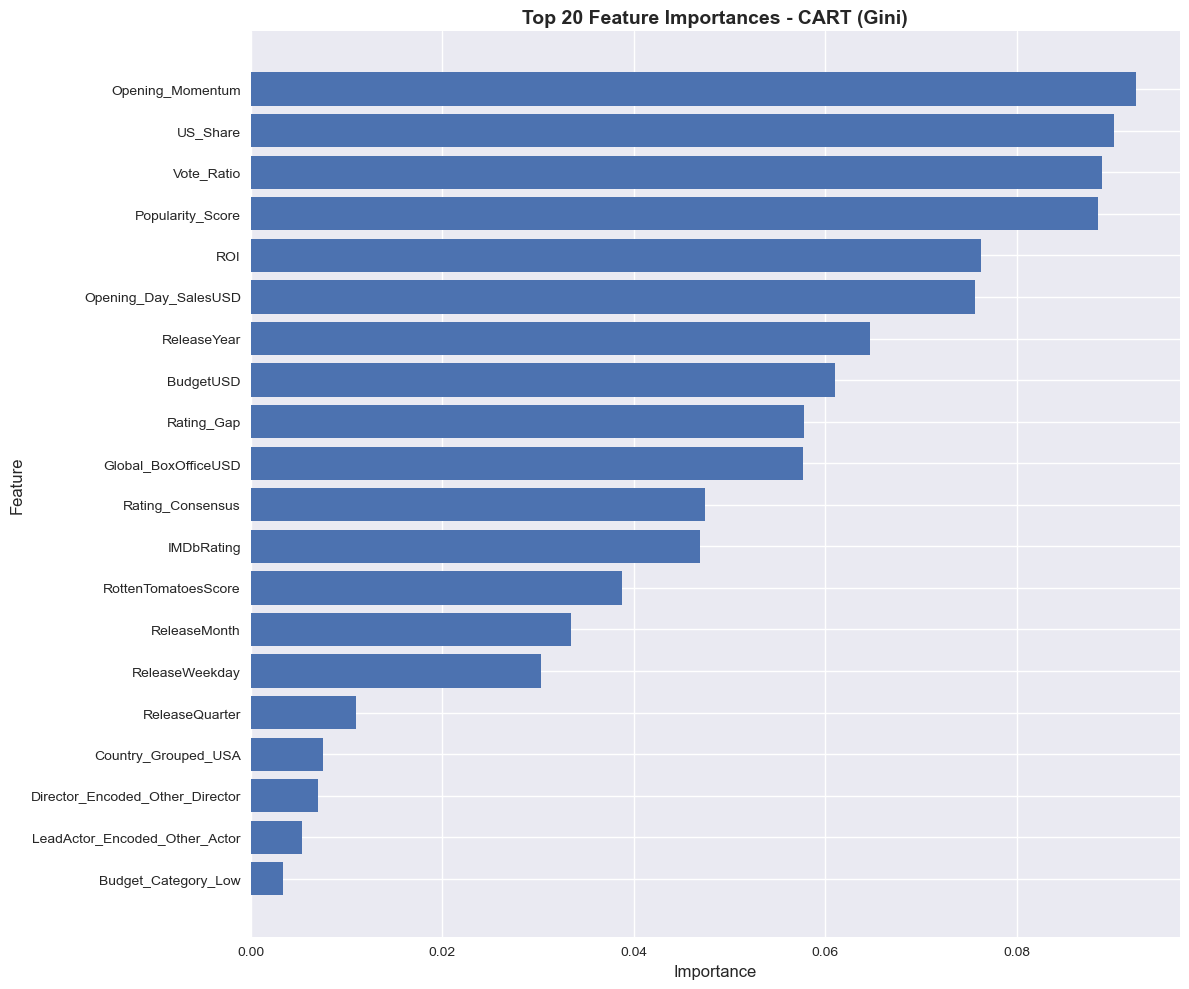


TREE VISUALIZATION

Tree too large to visualize (2161 leaves)

MODEL EVALUATION

CART (Gini-based)
           Metric  Value
         Accuracy 0.1224
Precision (macro) 0.1225
   Recall (macro) 0.1224
 F1-Score (macro) 0.1159
  Prediction time 0.025s

Confusion Matrix:
                  Pred_Action  Pred_Comedy  Pred_Documentary  Pred_Drama  \
True_Action               478          354               337         430   
True_Comedy               431          373               347         493   
True_Documentary          480          389               316         456   
True_Drama                483          357               313         441   
True_Horror               505          342               335         423   
True_Romance              428          344               324         451   
True_Sci-Fi               446          365               338         411   
True_Thriller             474          405               329         395   

                  Pred_Horror  Pred_Romance  P

In [17]:
# %% [Decision Trees - CART (Gini-based)]
from sklearn.tree import plot_tree
import time

print("=" * 80)
print("DECISION TREE - CART (Gini-based)")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep = prep_std.fit_transform(X_train)
X_test_prep = prep_std.transform(X_test)

print(f"Training set shape: {X_train_prep.shape}")
print(f"Test set shape: {X_test_prep.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"\nClass distribution in training:")
print(y_train.value_counts().sort_index())

# ============================================================================
# STEP 1: Quick baseline model
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: BASELINE MODEL (default parameters)")
print("=" * 80)

baseline_cart = DecisionTreeClassifier(
    criterion='gini',  # CART uses Gini impurity
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=30,
    min_samples_split=50,
    min_samples_leaf=20
)

start_time = time.time()
baseline_cart.fit(X_train_prep, y_train)
baseline_time = time.time() - start_time

print(f"\nBaseline training completed in {baseline_time:.2f}s")
print(f"Tree depth: {baseline_cart.get_depth()}")
print(f"Number of leaves: {baseline_cart.get_n_leaves()}")

# Baseline predictions
y_train_pred_baseline = baseline_cart.predict(X_train_prep)
y_test_pred_baseline = baseline_cart.predict(X_test_prep)

train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_acc_baseline = accuracy_score(y_test, y_test_pred_baseline)
test_f1_baseline = precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[2]

print(f"\nBaseline performance:")
print(f"  Training accuracy: {train_acc_baseline:.4f}")
print(f"  Test accuracy: {test_acc_baseline:.4f}")
print(f"  Test F1-score: {test_f1_baseline:.4f}")
print(f"  Overfitting gap: {(train_acc_baseline - test_acc_baseline):.4f}")

print(f"\nBaseline predictions distribution:")
print(pd.Series(y_test_pred_baseline).value_counts().sort_index())

# ============================================================================
# STEP 2: Grid search with optimized parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: HYPERPARAMETER TUNING")
print("=" * 80)

# Optimized parameter grid for CART
param_grid_cart = {
    'max_depth': [15, 20, 25, 30, 35],
    'min_samples_split': [20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_impurity_decrease': [0.0, 0.0001, 0.0005, 0.001],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.0001, 0.0005, 0.001]  # Cost-complexity pruning
}

# Create sample for grid search
print("\nCreating sample for GridSearch...")
n_per_class_grid = min(3000, len(y_train) // len(y_train.unique()))
X_grid_df, y_grid = stratified_sample(X_train, y_train, n_per_class_grid)
X_grid = prep_std.fit_transform(X_grid_df)

print(f"GridSearch sample size: {len(X_grid):,}")
print(f"Classes in grid sample:")
print(y_grid.value_counts().sort_index())

dt_cart_base = DecisionTreeClassifier(
    criterion='gini',
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

grid_cart = GridSearchCV(
    dt_cart_base,
    param_grid_cart,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV (this may take several minutes)...")
start_time = time.time()
grid_cart.fit(X_grid, y_grid)
grid_time = time.time() - start_time

print(f"\nGridSearch completed in {grid_time/60:.1f} minutes")
print(f"Best parameters: {grid_cart.best_params_}")
print(f"Best CV F1-score (macro): {grid_cart.best_score_:.4f}")

# Show top 10 parameter combinations
results_df = pd.DataFrame(grid_cart.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 10 parameter combinations:")
for idx, row in top_10.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")

# ============================================================================
# STEP 3: Train final model with best parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: TRAINING FINAL MODEL")
print("=" * 80)

best_cart = DecisionTreeClassifier(
    criterion='gini',
    **grid_cart.best_params_,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

start_time = time.time()
best_cart.fit(X_train_prep, y_train)
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f}s")
print(f"Tree depth: {best_cart.get_depth()}")
print(f"Number of leaves: {best_cart.get_n_leaves()}")
print(f"Number of nodes: {best_cart.tree_.node_count}")

# Fallback if tree didn't grow
if best_cart.get_depth() == 0:
    print("\n⚠️  ERROR: Tree did not grow! Using baseline model instead...")
    best_cart = baseline_cart

# Training performance
y_train_pred = best_cart.predict(X_train_prep)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = precision_recall_fscore_support(y_train, y_train_pred, average='macro', zero_division=0)[2]

print(f"\nTraining performance:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  F1-score (macro): {train_f1:.4f}")

# ============================================================================
# STEP 4: Feature importance
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

feature_names_expanded = []
for name, transformer, cols in prep_std.transformers_:
    if name == "num":
        feature_names_expanded.extend(cols)
    elif name == "cat":
        encoder = transformer.named_steps['onehot']
        cat_features = encoder.get_feature_names_out(cols)
        feature_names_expanded.extend(cat_features)

importance_df = pd.DataFrame({
    'feature': feature_names_expanded,
    'importance': best_cart.feature_importances_
}).sort_values('importance', ascending=False)

# Show only features with importance > 0
important_features = importance_df[importance_df['importance'] > 0]
print(f"\nNumber of features used: {len(important_features)}")
print(f"\nTop 25 Most Important Features:")
print(important_features.head(25).to_string(index=False))

# Plot top 20
if len(important_features) > 0:
    plt.figure(figsize=(12, 10))
    top_features = important_features.head(20)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 20 Feature Importances - CART (Gini)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# STEP 5: Tree visualization
# ============================================================================
print("\n" + "=" * 80)
print("TREE VISUALIZATION")
print("=" * 80)

if best_cart.get_depth() > 0 and best_cart.get_n_leaves() <= 200:
    print(f"\nGenerating tree visualization (first 4 levels)...")
    
    fig, ax = plt.subplots(figsize=(35, 20))
    plot_tree(
        best_cart,
        filled=True,
        feature_names=feature_names_expanded,
        class_names=[str(c) for c in sorted(best_cart.classes_)],
        rounded=True,
        fontsize=7,
        max_depth=4,
        ax=ax,
        proportion=True,
        precision=2,
        impurity=True
    )
    plt.title(f"CART Decision Tree (first 4 of {best_cart.get_depth()} levels)", 
              fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print(f"Note: Full tree has {best_cart.get_depth()} levels and {best_cart.get_n_leaves()} leaves")
elif best_cart.get_depth() == 0:
    print("\n⚠️  Tree did not grow - cannot visualize")
else:
    print(f"\nTree too large to visualize ({best_cart.get_n_leaves()} leaves)")

# ============================================================================
# STEP 6: Comprehensive model evaluation
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

res_cart = evaluate_model("CART (Gini-based)", best_cart, X_test_prep, y_test, verbose=True)

# ============================================================================
# STEP 7: Detailed analysis
# ============================================================================
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 80)

y_test_pred = best_cart.predict(X_test_prep)

# Per-class metrics
print("\nPer-class performance:")
per_class_metrics = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
per_class_df = pd.DataFrame(per_class_metrics).transpose()
per_class_df = per_class_df[per_class_df.index.isin(sorted(y_test.unique()))]
per_class_df = per_class_df.sort_values('f1-score', ascending=False)
print(per_class_df[['precision', 'recall', 'f1-score', 'support']].to_string())

# Overfitting analysis
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {res_cart['accuracy']:.4f}")
print(f"Gap: {(train_acc - res_cart['accuracy']):.4f}")

if train_acc - res_cart['accuracy'] > 0.20:
    print("\n⚠️  Significant overfitting detected")
    print("Recommendations: increase min_samples_leaf, decrease max_depth, or increase ccp_alpha")
elif train_acc - res_cart['accuracy'] < 0.05:
    print("\n⚠️  Possible underfitting - model might be too constrained")
    print("Recommendations: decrease min_samples_leaf, increase max_depth")
else:
    print("\n✓ Model generalization appears reasonable")

# Prediction distribution analysis
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print("\nPredicted distribution:")
print(pd.Series(y_test_pred).value_counts().sort_index())

# Check for collapsed predictions
unique_predictions = len(np.unique(y_test_pred))
print(f"\nUnique classes predicted: {unique_predictions} out of {len(np.unique(y_test))}")

if unique_predictions < len(np.unique(y_test)):
    missing_classes = set(y_test.unique()) - set(y_test_pred)
    print(f"⚠️  Model never predicts: {missing_classes}")

# ============================================================================
# STEP 8: Comparison with baseline
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: TUNED vs BASELINE")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline (default)', 'Tuned (GridSearch)'],
    'Test Accuracy': [test_acc_baseline, res_cart['accuracy']],
    'Test F1 (macro)': [test_f1_baseline, res_cart['f1_macro']],
    'Test Precision': [
        precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[0],
        res_cart['precision_macro']
    ],
    'Test Recall': [
        precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[1],
        res_cart['recall_macro']
    ],
    'Tree Depth': [baseline_cart.get_depth(), best_cart.get_depth()],
    'Num Leaves': [baseline_cart.get_n_leaves(), best_cart.get_n_leaves()]
})

print(comparison_df.to_string(index=False))

improvement = res_cart['accuracy'] - test_acc_baseline
print(f"\nAccuracy improvement: {improvement:+.4f}")

# ============================================================================
# STEP 9: Gini impurity analysis
# ============================================================================
print("\n" + "=" * 80)
print("GINI IMPURITY ANALYSIS")
print("=" * 80)

print(f"\nRoot node Gini impurity: {best_cart.tree_.impurity[0]:.4f}")
print(f"Average leaf Gini impurity: {np.mean([best_cart.tree_.impurity[i] for i in range(best_cart.tree_.node_count) if best_cart.tree_.children_left[i] == best_cart.tree_.children_right[i]]):.4f}")

# Most important splits
print("\nTop 5 most important splits (by weighted impurity decrease):")
node_samples = best_cart.tree_.n_node_samples
node_impurity = best_cart.tree_.impurity
children_left = best_cart.tree_.children_left
children_right = best_cart.tree_.children_right

split_importance = []
for i in range(best_cart.tree_.node_count):
    if children_left[i] != children_right[i]:  # Not a leaf
        left_samples = node_samples[children_left[i]]
        right_samples = node_samples[children_right[i]]
        parent_samples = node_samples[i]
        
        weighted_decrease = parent_samples * node_impurity[i] - \
                          left_samples * node_impurity[children_left[i]] - \
                          right_samples * node_impurity[children_right[i]]
        
        split_importance.append({
            'node': i,
            'feature': best_cart.tree_.feature[i],
            'threshold': best_cart.tree_.threshold[i],
            'importance': weighted_decrease,
            'samples': parent_samples
        })

if split_importance:
    split_df = pd.DataFrame(split_importance).sort_values('importance', ascending=False).head(5)
    split_df['feature_name'] = split_df['feature'].apply(lambda x: feature_names_expanded[x] if x < len(feature_names_expanded) else 'Unknown')
    print(split_df[['node', 'feature_name', 'threshold', 'importance', 'samples']].to_string(index=False))

print("\n" + "=" * 80)
print("CART TRAINING COMPLETE")
print("=" * 80)
print(f"Final Test Accuracy: {res_cart['accuracy']:.4f}")
print(f"Final Test F1-score: {res_cart['f1_macro']:.4f}")
print(f"Final Test Precision: {res_cart['precision_macro']:.4f}")
print(f"Final Test Recall: {res_cart['recall_macro']:.4f}")

## 4. Naive Bayes

Train and evaluate a Naive Bayes classifier.

In [36]:

# GaussianNB (para continuas)
nb_gaussian = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", GaussianNB())
])

# MultinomialNB (requiere no-negatividad; MinMax ayuda)
nb_mult = Pipeline(steps=[
    ("prep", prep_minmax),
    ("clf", MultinomialNB())
])

# Pequeño grid para Multinomial
grid_nb_mult = {"clf__alpha": [0.0, 0.5, 1.0]}

gs_nb_mult = GridSearchCV(
    estimator=nb_mult, param_grid=grid_nb_mult,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_nb_mult.fit(X_train, y_train)

print("\n[NB-Mult] mejores params:", gs_nb_mult.best_params_)
print("[NB-Mult] CV mean scores:", {m: gs_nb_mult.cv_results_[f"mean_test_{m}"][gs_nb_mult.best_index_] for m in scoring})

# Entrena GaussianNB (sin grid)
nb_gaussian.fit(X_train, y_train)

# Evalúa ambos y elige mejor por F1 macro
res_nbG = evaluate_model("Naive Bayes (Gaussian)", nb_gaussian, X_test, y_test)
res_nbM = evaluate_model("Naive Bayes (Multinomial)", gs_nb_mult.best_estimator_, X_test, y_test)

best_nb_res = res_nbM if res_nbM["f1_macro"] >= res_nbG["f1_macro"] else res_nbG
best_nb_name = best_nb_res["model"]
print(f"\n[NB] Mejor variante: {best_nb_name}")



[NB-Mult] mejores params: {'clf__alpha': 0.0}
[NB-Mult] CV mean scores: {'f1_macro': 0.09664652087151866, 'accuracy': 0.12437502140493366}

== Naive Bayes (Gaussian) ==
accuracy           0.129400
precision_macro    0.136299
recall_macro       0.129400
f1_macro           0.081846
dtype: float64

Matriz de confusión:
 [[141  69  41  15  46 873  18  47]
 [131  87  48   9  61 858  16  40]
 [127  73  46   8  53 893  16  34]
 [125  88  44  19  45 878  17  34]
 [130  80  48  11  52 853  28  48]
 [119  64  47   9  50 892  19  50]
 [136  69  47   9  55 884  12  38]
 [136  70  32  12  56 889  10  45]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.13      0.11      0.12      1250
      Comedy       0.14      0.07      0.09      1250
 Documentary       0.13      0.04      0.06      1250
       Drama       0.21      0.02      0.03      1250
      Horror       0.12      0.04      0.06      1250
     Romance       0.13      0.71      0.22      1250

NAIVE BAYES CLASSIFIERS

Preparing data...
Training set shape: (120000, 133)
Test set shape: (30000, 133)

PART 1: GAUSSIAN NAIVE BAYES

Gaussian NB works best with StandardScaler (continuous features)
Testing with different var_smoothing values for better performance...

Running GridSearchCV for Gaussian NB...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

GridSearch completed in 11.00s
Best var_smoothing: 0.001
Best CV F1-score: 0.1093
Training accuracy: 0.1380

Class priors learned:
  Action         : 0.1250
  Comedy         : 0.1250
  Documentary    : 0.1250
  Drama          : 0.1250
  Horror         : 0.1250
  Romance        : 0.1250
  Sci-Fi         : 0.1250
  Thriller       : 0.1250

GAUSSIAN NB - MODEL EVALUATION

Naive Bayes (Gaussian)
           Metric  Value
         Accuracy 0.1234
Precision (macro) 0.1229
   Recall (macro) 0.1234
 F1-Score (macro) 0.1096
  Prediction time 0.223s

Confusion Matrix:
                  Pred_Action  Pred_Comedy  Pred_Documentary  

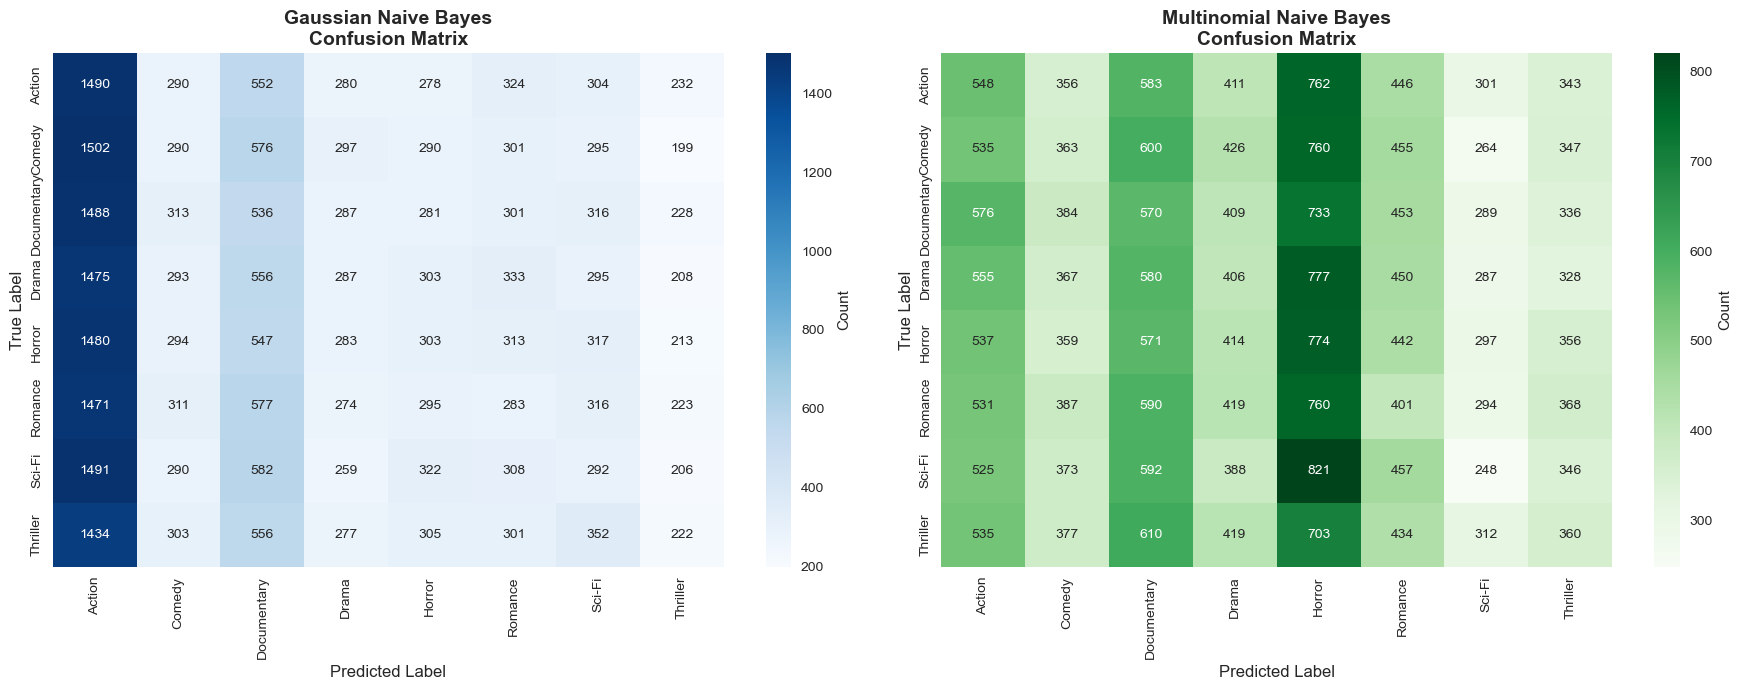


VISUALIZATION - METRICS COMPARISON


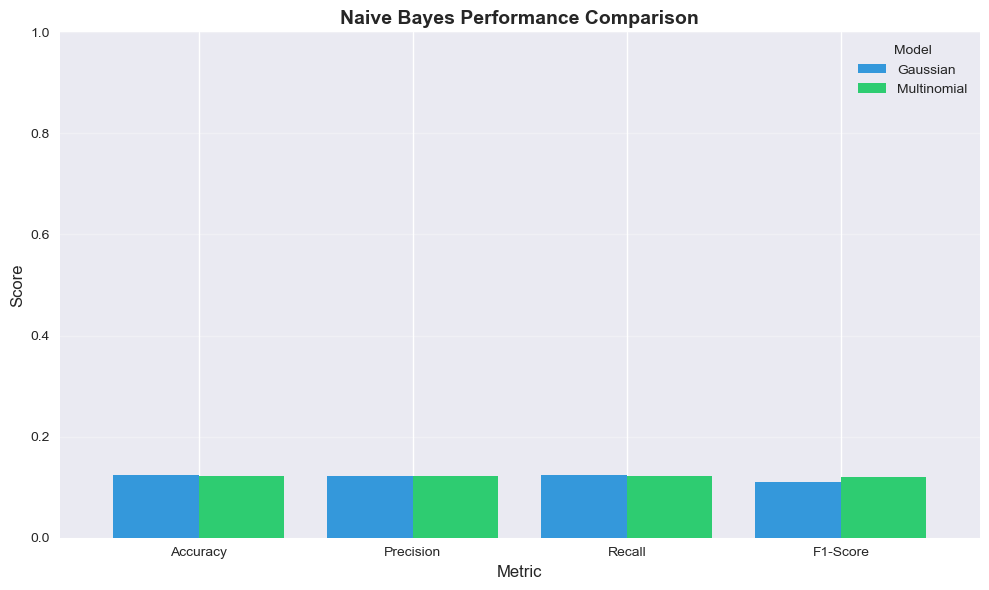


VISUALIZATION - PER-CLASS F1-SCORES


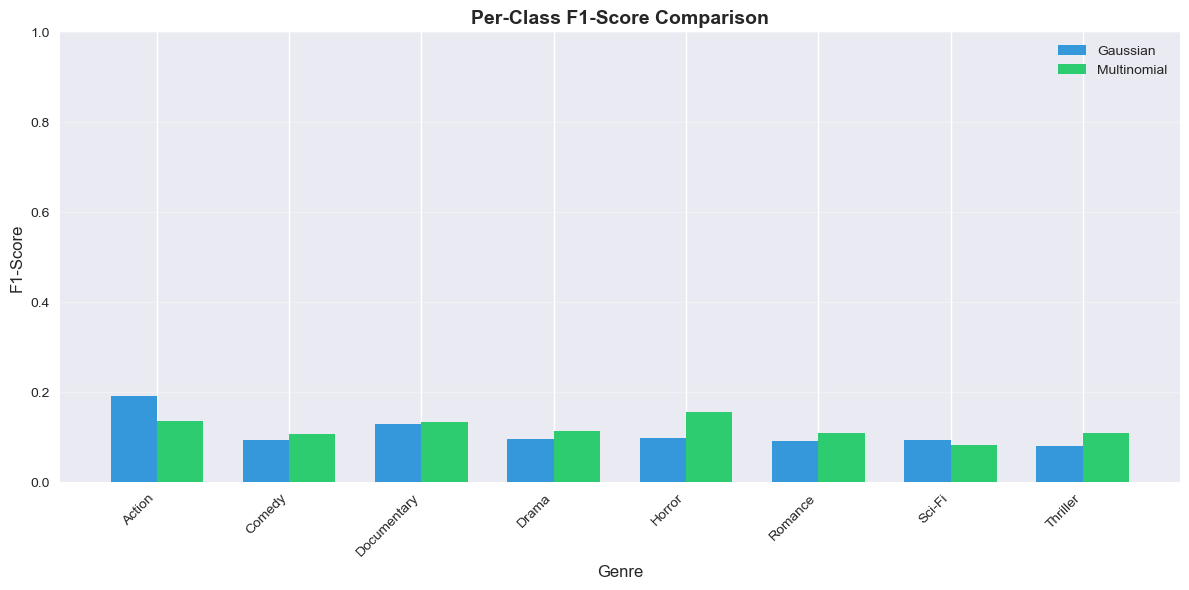


Per-class F1-scores:
      Genre  Gaussian  Multinomial
     Action  0.191259     0.135442
     Comedy  0.094555     0.108100
Documentary  0.130224     0.134975
      Drama  0.095762     0.115308
     Horror  0.098906     0.157317
    Romance  0.091085     0.110044
     Sci-Fi  0.093635     0.082092
   Thriller  0.081007     0.110193

VISUALIZATION - HYPERPARAMETER IMPACT


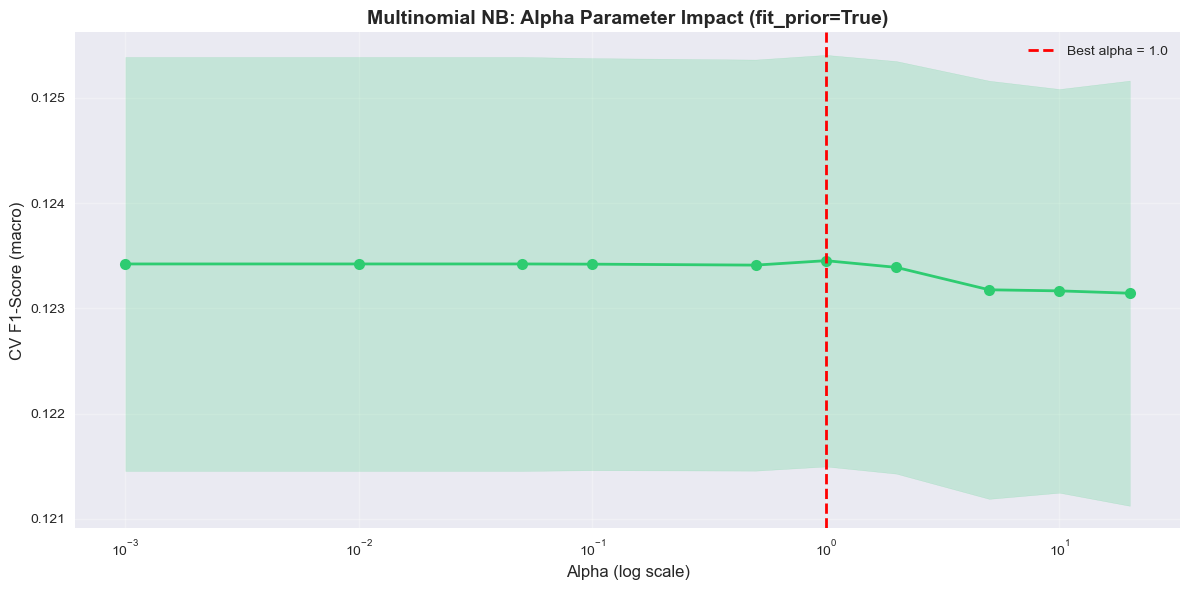


PREDICTION DISTRIBUTION ANALYSIS

True distribution in test set:
Genre
Action         3750
Comedy         3750
Documentary    3750
Drama          3750
Horror         3750
Romance        3750
Sci-Fi         3750
Thriller       3750
Name: count, dtype: int64

Gaussian NB predictions:
Action         11831
Comedy          2384
Documentary     4482
Drama           2244
Horror          2377
Romance         2464
Sci-Fi          2487
Thriller        1731
Name: count, dtype: int64

Multinomial NB predictions:
Action         4342
Comedy         2966
Documentary    4696
Drama          3292
Horror         6090
Romance        3538
Sci-Fi         2292
Thriller       2784
Name: count, dtype: int64

Gaussian NB predicts 8 out of 8 classes
Multinomial NB predicts 8 out of 8 classes

PROBABILITY CALIBRATION ANALYSIS

Mean prediction confidence:
  Gaussian NB: 0.5167
  Multinomial NB: 0.1385


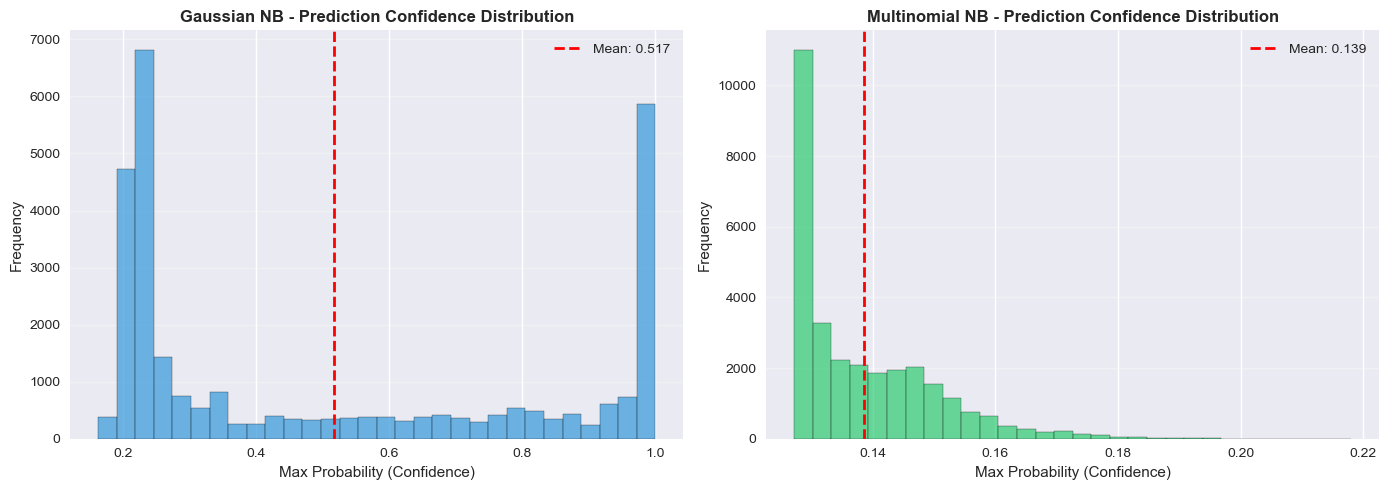


NAIVE BAYES TRAINING COMPLETE
Best Model: Naive Bayes (Multinomial)
Final Test Accuracy: 0.1223
Final Test F1-score: 0.1192
Final Test Precision: 0.1214
Final Test Recall: 0.1223


In [19]:
# %% [Naive Bayes]
import time
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("NAIVE BAYES CLASSIFIERS")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep_std = prep_std.fit_transform(X_train)
X_test_prep_std = prep_std.transform(X_test)
X_train_prep_minmax = prep_minmax.fit_transform(X_train)
X_test_prep_minmax = prep_minmax.transform(X_test)

print(f"Training set shape: {X_train_prep_std.shape}")
print(f"Test set shape: {X_test_prep_std.shape}")

# ============================================================================
# PART 1: GAUSSIAN NAIVE BAYES (for continuous features)
# ============================================================================
print("\n" + "=" * 80)
print("PART 1: GAUSSIAN NAIVE BAYES")
print("=" * 80)

print("\nGaussian NB works best with StandardScaler (continuous features)")
print("Testing with different var_smoothing values for better performance...")

# Grid search for Gaussian NB (often overlooked!)
param_grid_gaussian = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

nb_gaussian_base = GaussianNB()

grid_nb_gaussian = GridSearchCV(
    nb_gaussian_base,
    param_grid_gaussian,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for Gaussian NB...")
start_time = time.time()
grid_nb_gaussian.fit(X_train_prep_std, y_train)
grid_time_gaussian = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_gaussian:.2f}s")
print(f"Best var_smoothing: {grid_nb_gaussian.best_params_['var_smoothing']}")
print(f"Best CV F1-score: {grid_nb_gaussian.best_score_:.4f}")

# Get best Gaussian NB
nb_gaussian = grid_nb_gaussian.best_estimator_

# Training performance
y_train_pred_gaussian = nb_gaussian.predict(X_train_prep_std)
train_acc_gaussian = accuracy_score(y_train, y_train_pred_gaussian)
print(f"Training accuracy: {train_acc_gaussian:.4f}")

# Class priors
print("\nClass priors learned:")
for cls, prior in zip(nb_gaussian.classes_, nb_gaussian.class_prior_):
    print(f"  {cls:15s}: {prior:.4f}")

# Evaluate Gaussian NB
print("\n" + "=" * 80)
print("GAUSSIAN NB - MODEL EVALUATION")
print("=" * 80)

res_gaussian = evaluate_model("Naive Bayes (Gaussian)", nb_gaussian, X_test_prep_std, y_test, verbose=True)

# ============================================================================
# PART 2: MULTINOMIAL NAIVE BAYES (for non-negative features)
# ============================================================================
print("\n" + "=" * 80)
print("PART 2: MULTINOMIAL NAIVE BAYES")
print("=" * 80)

print("\nMultinomial NB requires non-negative features (using MinMaxScaler)")
print("Tuning smoothing parameter 'alpha'...")

# Ensure non-negative values
X_train_prep_minmax_pos = X_train_prep_minmax.copy()
X_test_prep_minmax_pos = X_test_prep_minmax.copy()

if (X_train_prep_minmax_pos < 0).any():
    print("Shifting to ensure non-negative values...")
    min_val = X_train_prep_minmax_pos.min()
    X_train_prep_minmax_pos = X_train_prep_minmax_pos - min_val + 1e-10
    X_test_prep_minmax_pos = X_test_prep_minmax_pos - min_val + 1e-10

# Grid search for Multinomial NB
param_grid_nb_mult = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0],
    'fit_prior': [True, False]
}

nb_mult_base = MultinomialNB()

grid_nb_mult = GridSearchCV(
    nb_mult_base,
    param_grid_nb_mult,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for Multinomial NB...")
start_time = time.time()
grid_nb_mult.fit(X_train_prep_minmax_pos, y_train)
grid_time_mult = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_mult:.2f}s")
print(f"Best parameters: {grid_nb_mult.best_params_}")
print(f"Best CV F1-score: {grid_nb_mult.best_score_:.4f}")

# Show top 5 configurations
results_df = pd.DataFrame(grid_nb_mult.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 parameter combinations:")
for idx, row in top_5.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")

# Get best Multinomial NB
best_nb_mult = grid_nb_mult.best_estimator_

# Training performance
y_train_pred_mult = best_nb_mult.predict(X_train_prep_minmax_pos)
train_acc_mult = accuracy_score(y_train, y_train_pred_mult)
print(f"\nTraining accuracy: {train_acc_mult:.4f}")

# Class priors
print("\nClass log priors learned:")
for cls, prior in zip(best_nb_mult.classes_, best_nb_mult.class_log_prior_):
    print(f"  {cls:15s}: {np.exp(prior):.4f}")

# Evaluate Multinomial NB
print("\n" + "=" * 80)
print("MULTINOMIAL NB - MODEL EVALUATION")
print("=" * 80)

res_multinomial = evaluate_model("Naive Bayes (Multinomial)", best_nb_mult, X_test_prep_minmax_pos, y_test, verbose=True)

# ============================================================================
# PART 3: COMPARISON AND VISUALIZATION
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: GAUSSIAN vs MULTINOMIAL")
print("=" * 80)

# Comparison table
comparison_df = pd.DataFrame({
    'Model': ['Gaussian NB', 'Multinomial NB'],
    'Test Accuracy': [res_gaussian['accuracy'], res_multinomial['accuracy']],
    'Test Precision': [res_gaussian['precision_macro'], res_multinomial['precision_macro']],
    'Test Recall': [res_gaussian['recall_macro'], res_multinomial['recall_macro']],
    'Test F1-score': [res_gaussian['f1_macro'], res_multinomial['f1_macro']],
    'Training Time': [f"{grid_time_gaussian:.2f}s", f"{grid_time_mult:.2f}s"],
    'Prediction Time': [f"{res_gaussian['prediction_time']:.3f}s", f"{res_multinomial['prediction_time']:.3f}s"]
})

print("\n" + comparison_df.to_string(index=False))

# Select best model
if res_multinomial['f1_macro'] >= res_gaussian['f1_macro']:
    best_nb_model = best_nb_mult
    best_nb_name = "Naive Bayes (Multinomial)"
    best_nb_res = res_multinomial
    best_X_test = X_test_prep_minmax_pos
    best_y_pred = best_nb_mult.predict(X_test_prep_minmax_pos)
else:
    best_nb_model = nb_gaussian
    best_nb_name = "Naive Bayes (Gaussian)"
    best_nb_res = res_gaussian
    best_X_test = X_test_prep_std
    best_y_pred = nb_gaussian.predict(X_test_prep_std)

print(f"\n✓ Best variant: {best_nb_name}")
print(f"  F1-score: {best_nb_res['f1_macro']:.4f}")

# ============================================================================
# PART 4: VISUALIZATION - Confusion Matrix Comparison
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - CONFUSION MATRICES")
print("=" * 80)

y_pred_gaussian = nb_gaussian.predict(X_test_prep_std)
y_pred_mult = best_nb_mult.predict(X_test_prep_minmax_pos)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gaussian confusion matrix
cm_gaussian = confusion_matrix(y_test, y_pred_gaussian)
sns.heatmap(cm_gaussian, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Gaussian Naive Bayes\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Multinomial confusion matrix
cm_mult = confusion_matrix(y_test, y_pred_mult)
sns.heatmap(cm_mult, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Multinomial Naive Bayes\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================================
# PART 5: VISUALIZATION - Performance Metrics Comparison
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - METRICS COMPARISON")
print("=" * 80)

metrics_comparison = pd.DataFrame({
    'Gaussian': [res_gaussian['accuracy'], res_gaussian['precision_macro'], 
                 res_gaussian['recall_macro'], res_gaussian['f1_macro']],
    'Multinomial': [res_multinomial['accuracy'], res_multinomial['precision_macro'], 
                    res_multinomial['recall_macro'], res_multinomial['f1_macro']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

fig, ax = plt.subplots(figsize=(10, 6))
metrics_comparison.plot(kind='bar', ax=ax, width=0.8, color=['#3498db', '#2ecc71'])
ax.set_title('Naive Bayes Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(title='Model', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# PART 6: VISUALIZATION - Per-Class Performance (FIXED)
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - PER-CLASS F1-SCORES")
print("=" * 80)

# Calculate per-class F1 scores correctly
classes = sorted(y_test.unique())

# Use classification_report to get per-class metrics
report_gaussian = classification_report(y_test, y_pred_gaussian, output_dict=True, zero_division=0)
report_mult = classification_report(y_test, y_pred_mult, output_dict=True, zero_division=0)

f1_gaussian_per_class = [report_gaussian[str(cls)]['f1-score'] for cls in classes]
f1_mult_per_class = [report_mult[str(cls)]['f1-score'] for cls in classes]

per_class_df = pd.DataFrame({
    'Genre': classes,
    'Gaussian': f1_gaussian_per_class,
    'Multinomial': f1_mult_per_class
})

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, per_class_df['Gaussian'], width, label='Gaussian', color='#3498db')
bars2 = ax.bar(x + width/2, per_class_df['Multinomial'], width, label='Multinomial', color='#2ecc71')

ax.set_xlabel('Genre', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nPer-class F1-scores:")
print(per_class_df.to_string(index=False))

# ============================================================================
# PART 7: VISUALIZATION - Hyperparameter Impact
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - HYPERPARAMETER IMPACT")
print("=" * 80)

# Extract alpha values and scores for Multinomial
alpha_results = []
for idx, params in enumerate(results_df['params']):
    if params['fit_prior'] == True:  # Show only fit_prior=True for clarity
        alpha_results.append({
            'alpha': params['alpha'],
            'mean_score': results_df['mean_test_score'].iloc[idx],
            'std_score': results_df['std_test_score'].iloc[idx]
        })

if alpha_results:
    alpha_df = pd.DataFrame(alpha_results).sort_values('alpha')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(alpha_df['alpha'], alpha_df['mean_score'], 'o-', linewidth=2, markersize=8, color='#2ecc71')
    ax.fill_between(alpha_df['alpha'], 
                    alpha_df['mean_score'] - alpha_df['std_score'], 
                    alpha_df['mean_score'] + alpha_df['std_score'], 
                    alpha=0.2, color='#2ecc71')
    ax.axvline(grid_nb_mult.best_params_['alpha'], color='red', linestyle='--', 
               label=f"Best alpha = {grid_nb_mult.best_params_['alpha']}", linewidth=2)
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (log scale)', fontsize=12)
    ax.set_ylabel('CV F1-Score (macro)', fontsize=12)
    ax.set_title('Multinomial NB: Alpha Parameter Impact (fit_prior=True)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# PART 8: PREDICTION DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print(f"\nGaussian NB predictions:")
print(pd.Series(y_pred_gaussian).value_counts().sort_index())

print(f"\nMultinomial NB predictions:")
print(pd.Series(y_pred_mult).value_counts().sort_index())

# Check for collapsed predictions
unique_pred_gaussian = len(np.unique(y_pred_gaussian))
unique_pred_mult = len(np.unique(y_pred_mult))

print(f"\nGaussian NB predicts {unique_pred_gaussian} out of {len(np.unique(y_test))} classes")
print(f"Multinomial NB predicts {unique_pred_mult} out of {len(np.unique(y_test))} classes")

if unique_pred_gaussian < len(np.unique(y_test)):
    missing = set(y_test.unique()) - set(y_pred_gaussian)
    print(f"⚠️  Gaussian NB never predicts: {missing}")

if unique_pred_mult < len(np.unique(y_test)):
    missing = set(y_test.unique()) - set(y_pred_mult)
    print(f"⚠️  Multinomial NB never predicts: {missing}")

# ============================================================================
# PART 9: PROBABILITY CALIBRATION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("PROBABILITY CALIBRATION ANALYSIS")
print("=" * 80)

# Get prediction probabilities
proba_gaussian = nb_gaussian.predict_proba(X_test_prep_std)
proba_mult = best_nb_mult.predict_proba(X_test_prep_minmax_pos)

# Calculate mean max probability (confidence)
mean_conf_gaussian = np.mean(np.max(proba_gaussian, axis=1))
mean_conf_mult = np.mean(np.max(proba_mult, axis=1))

print(f"\nMean prediction confidence:")
print(f"  Gaussian NB: {mean_conf_gaussian:.4f}")
print(f"  Multinomial NB: {mean_conf_mult:.4f}")

# Confidence histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.max(proba_gaussian, axis=1), bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Max Probability (Confidence)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Gaussian NB - Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(mean_conf_gaussian, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf_gaussian:.3f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(np.max(proba_mult, axis=1), bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Max Probability (Confidence)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Multinomial NB - Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[1].axvline(mean_conf_mult, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf_mult:.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("NAIVE BAYES TRAINING COMPLETE")
print("=" * 80)
print(f"Best Model: {best_nb_name}")
print(f"Final Test Accuracy: {best_nb_res['accuracy']:.4f}")
print(f"Final Test F1-score: {best_nb_res['f1_macro']:.4f}")
print(f"Final Test Precision: {best_nb_res['precision_macro']:.4f}")
print(f"Final Test Recall: {best_nb_res['recall_macro']:.4f}")

## 5. Support Vector Machine (SVM)

Train and evaluate a Support Vector Machine classifier.

In [53]:

# SVM es costoso. Submuestreo adicional para entrenar con tiempos razonables
n_per_class_svm = SAMPLE_SIZE_FOR_SVM // y_train.nunique()
X_svm_train, y_svm_train = stratified_sample(X_train, y_train, n_per_class_svm)

svm_pipe = Pipeline(steps=[
    ("prep", prep_std),
    ("clf", SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=RANDOM_STATE))
])

grid_svm = {
    "clf__C": [1, 5, 10],
    "clf__gamma": ["scale", 0.1]
}

gs_svm = GridSearchCV(
    estimator=svm_pipe, param_grid=grid_svm,
    scoring=scoring, refit="f1_macro", cv=cv, n_jobs=-1
)
gs_svm.fit(X_svm_train, y_svm_train)

print("\n[SVM] mejores params:", gs_svm.best_params_)
print("[SVM] CV mean scores:", {m: gs_svm.cv_results_[f"mean_test_{m}"][gs_svm.best_index_] for m in scoring})

# Evaluación SVM en X_test completo (preprocesado dentro del pipeline)
best_svm = gs_svm.best_estimator_
res_svm = evaluate_model("SVM (RBF)", best_svm, X_test, y_test)



[SVM] mejores params: {'clf__C': 5, 'clf__gamma': 'scale'}
[SVM] CV mean scores: {'f1_macro': 0.1273560941034949, 'accuracy': 0.12864992813965662}

== SVM (RBF) ==
accuracy           0.123400
precision_macro    0.123733
recall_macro       0.123400
f1_macro           0.121705
dtype: float64

Matriz de confusión:
 [[162 156 228 218 112 147 103 124]
 [167 140 227 215 110 149 121 121]
 [184 168 219 178 114 167 109 111]
 [170 139 207 215 115 158 106 140]
 [180 151 197 210 121 154 122 115]
 [173 150 210 224 135 135 121 102]
 [170 129 241 188 122 163 123 114]
 [196 126 208 222 100 161 118 119]]

Reporte por clase:
               precision    recall  f1-score   support

      Action       0.12      0.13      0.12      1250
      Comedy       0.12      0.11      0.12      1250
 Documentary       0.13      0.18      0.15      1250
       Drama       0.13      0.17      0.15      1250
      Horror       0.13      0.10      0.11      1250
     Romance       0.11      0.11      0.11      1250
    

## 6. Model Comparison

Compare the performance of all classifiers using accuracy and classification metrics.


=== COMPARATIVA (ordenado por F1_macro) ===
                            accuracy  precision_macro  recall_macro  f1_macro
model                                                                       
ID3 (from-scratch)           0.1281         0.128081        0.1281  0.128080
CART (sklearn)               0.1262         0.126566        0.1262  0.126003
SVM (RBF)                    0.1244         0.124997        0.1244  0.123396
Naive Bayes (Multinomial)    0.1253         0.111565        0.1253  0.097355


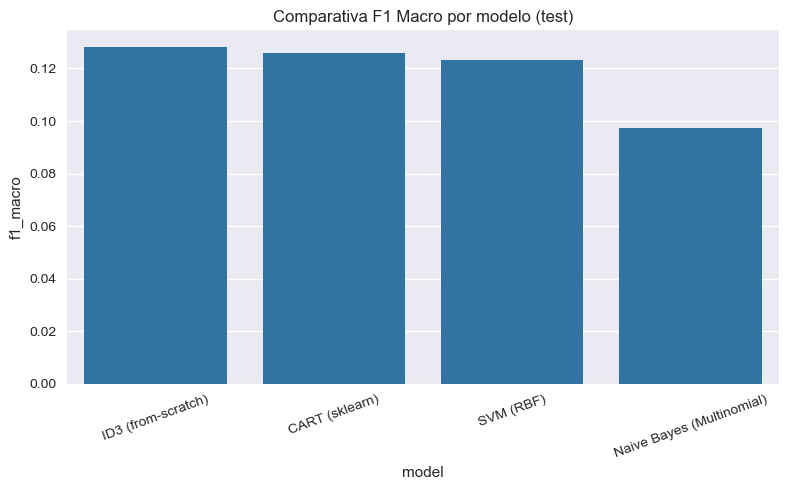

In [52]:

# %% [Comparativa final]
results = [res_cart, best_nb_res, res_svm, res_id3]
df_res = pd.DataFrame(results).set_index("model").sort_values("f1_macro", ascending=False)
print("\n=== COMPARATIVA (ordenado por F1_macro) ===\n", df_res)

# Guardar resultados a CSV (opcional)
df_res.to_csv("classification_results.csv", index=True)

# (Opcional) gráfico rápido de F1 macro
plt.figure(figsize=(8,5))
sns.barplot(x=df_res.index, y=df_res["f1_macro"], color="#1f77b4")
plt.title("Comparativa F1 Macro por modelo (test)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
